In [ ]:
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! kaggle datasets download -d msambare/fer2013

! unzip fer2013

In [2]:
import tensorflow as tf
import cv2
 
import os
import matplotlib.pyplot as plt
import numpy as np
 
from tensorflow.keras.utils import img_to_array, load_img


2024-05-09 09:39:30.720123: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Define name of each classes (all image folder names)
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral','sad', 'surprise']
 
# Print number of images for each class
folder_path = "data/"
for cls in classes:
    path = os.path.join('train', cls)
    lst = os.listdir(path)
    number_files = len(lst)
    print(cls, ': ', number_files)

angry :  3995
disgust :  436
fear :  4097
happy :  7215
neutral :  4965
sad :  4830
surprise :  3171


In [22]:
# Create a empty folder
os.makedirs('new_data')
# Create "train" folder inside new_data folder
os.makedirs('new_data/train')
# Crate sub-folders
for cls in classes:
    os.makedirs('new_data/train/'+cls)

In [23]:
import shutil
import random
 
num_files = 436
 
for cls in classes:
    # Downloaded original training image folder path for face emotion recognition
    src_path = os.path.join('train', cls)
    # Sub folder path
    dst_path = os.path.join('new_data', 'train', cls)
    src_files = os.listdir(src_path)
    # Select random 436 images from source directory
    src_select_files = random.sample(src_files, num_files)
 
    # Copy selected images to destination folder
    for file_name in src_select_files:
        full_file_name = os.path.join(src_path, file_name)
        if os.path.isfile(full_file_name):
            shutil.copy(full_file_name, dst_path)

In [24]:
folder_path = "new_data/"
for cls in classes:
    path = os.path.join(folder_path, 'train', cls)
    lst = os.listdir(path)
    number_files = len(lst)
    print(cls, ': ', number_files)

angry :  436
disgust :  436
fear :  436
happy :  436
neutral :  436
sad :  436
surprise :  436


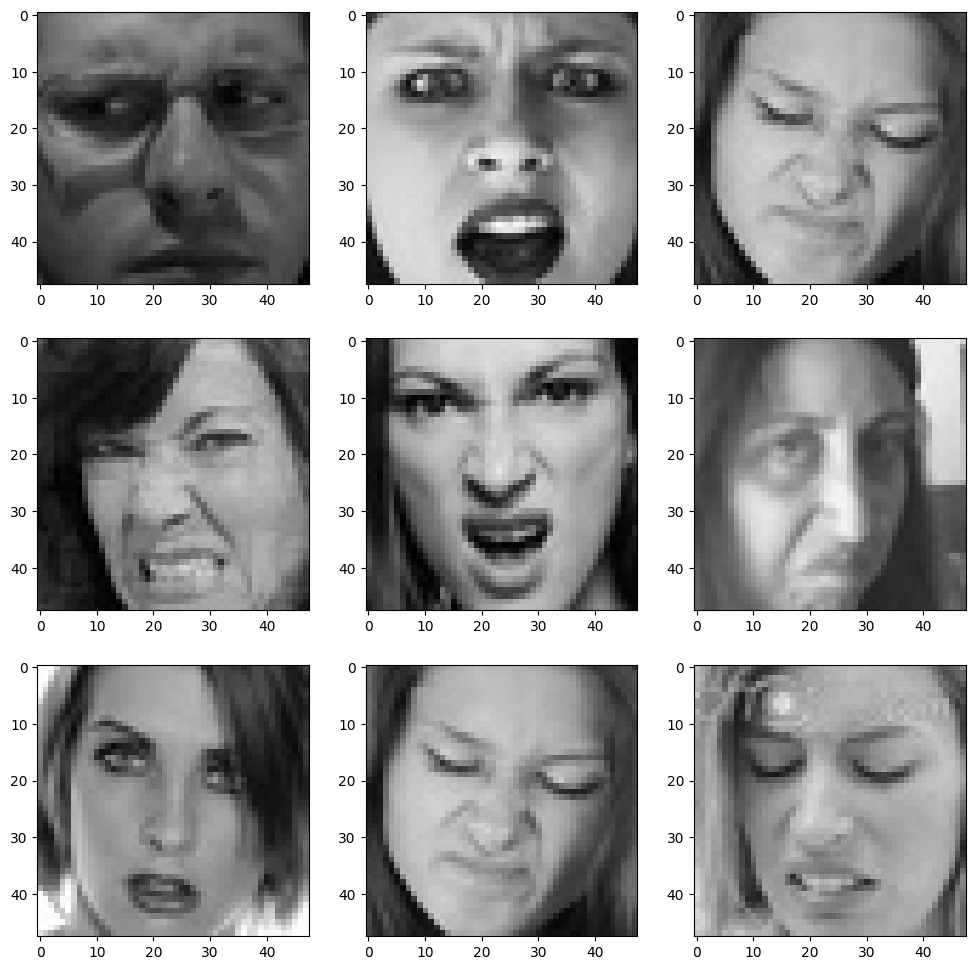

In [25]:
picture_size = 48
folder_path = "new_data/"
 
expression = 'disgust'
 
plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)   
plt.show()

In [26]:
img_size = 224 ## ImageNet => 224x224
training_data = []
 
def create_training_data():
    for category in classes:
        path = os.path.join(folder_path, 'train', category)
        class_num = classes.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

create_training_data()

In [28]:
images = np.array([item[0] for item in training_data])
labels = np.array([item[1] for item in training_data])

# Check the shape of image and label arrays
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (3052, 224, 224, 3)
Labels shape: (3052,)


In [30]:
img_array = cv2.imread('new_data/train/angry/Training_345125.jpg')
print('Input image shape: ', img_array.shape)
 
# Convert image to 224x224
img_size = 224 ## ImageNet => 224x224
new_array = cv2.resize(img_array, (img_size, img_size))
print('Converted image shape: ', new_array.shape)

Input image shape:  (48, 48, 3)
Converted image shape:  (224, 224, 3)


In [31]:
X = []
y = []
 
for features, label in training_data:
    X.append(features)
    y.append(label)
     
X = np.array(X).reshape(-1, img_size, img_size, 3) # converting it to 4 dimention
 
print(X.shape)
 
# Convert to array
Y = np.array(y)

(3052, 224, 224, 3)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
 
# Download Pre-trained MobileNet Model
model = tf.keras.applications.MobileNetV2() ## Pre-trained Model
 
# Print MobileNet architecture
model.summary()

In [33]:
# Defining first layer as input layer of Mobilenet
# Find the input layer by name
input_layer_name = model.layers[0].name
base_input = model.get_layer(input_layer_name).output
print(base_input)
 
# Removing last layer of MobileNet model
base_output = model.layers[-2].output
 
# Adding some extra layers
final_output = layers.Dense(128)(base_output) ## adding new layer, after the output of global pooling layer
final_output = layers.Activation('relu')(final_output) ## activation function
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
# Defining final layer with 7 classes
final_output = layers.Dense(7, activation = 'softmax')(final_output) ## 7 because my classes are 7
print(final_output)

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor>
<KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_160>


In [ ]:
custom_model = keras.Model(inputs = base_input, outputs = final_output) ## Final model architecture
# Print our custom model summary
custom_model.summary()
 
# Compiling the model to train
custom_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [35]:
custom_model.fit(X, Y, epochs = 25, batch_size = 8)

Epoch 1/25


2024-04-24 09:41:38.753649: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 459411456 exceeds 10% of free system memory.
2024-04-24 09:42:23.401165: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 38535168 exceeds 10% of free system memory.
2024-04-24 09:42:23.448921: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 38535168 exceeds 10% of free system memory.
2024-04-24 09:42:23.493840: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 38535168 exceeds 10% of free system memory.
2024-04-24 09:42:23.543951: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 39226368 exceeds 10% of free system memory.


382/382 ━━━━━━━━━━━━━━━━━━━━ 580s 1s/step - accuracy: 0.2482 - loss: 1.8947
Epoch 2/25
382/382 ━━━━━━━━━━━━━━━━━━━━ 533s 1s/step - accuracy: 0.3527 - loss: 1.6868
Epoch 3/25
382/382 ━━━━━━━━━━━━━━━━━━━━ 533s 1s/step - accuracy: 0.3946 - loss: 1.5741
Epoch 4/25
382/382 ━━━━━━━━━━━━━━━━━━━━ 529s 1s/step - accuracy: 0.4219 - loss: 1.5201
Epoch 5/25
382/382 ━━━━━━━━━━━━━━━━━━━━ 517s 1s/step - accuracy: 0.4555 - loss: 1.3763
Epoch 6/25
382/382 ━━━━━━━━━━━━━━━━━━━━ 508s 1s/step - accuracy: 0.4721 - loss: 1.3235
Epoch 7/25
382/382 ━━━━━━━━━━━━━━━━━━━━ 511s 1s/step - accuracy: 0.4653 - loss: 1.3475
Epoch 8/25
382/382 ━━━━━━━━━━━━━━━━━━━━ 509s 1s/step - accuracy: 0.5113 - loss: 1.2704
Epoch 9/25
382/382 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - accuracy: 0.5142 - loss: 1.2462
Epoch 10/25
382/382 ━━━━━━━━━━━━━━━━━━━━ 508s 1s/step - accuracy: 0.5443 - loss: 1.1536
Epoch 11/25
382/382 ━━━━━━━━━━━━━━━━━━━━ 508s 1s/step - accuracy: 0.5453 - loss: 1.1689
Epoch 12/25
382/382 ━━━━━━━━━━━━━━━━━━━━ 519s 1s/ste

In [ ]:
custom_model.save('facial_expression_model.h5')


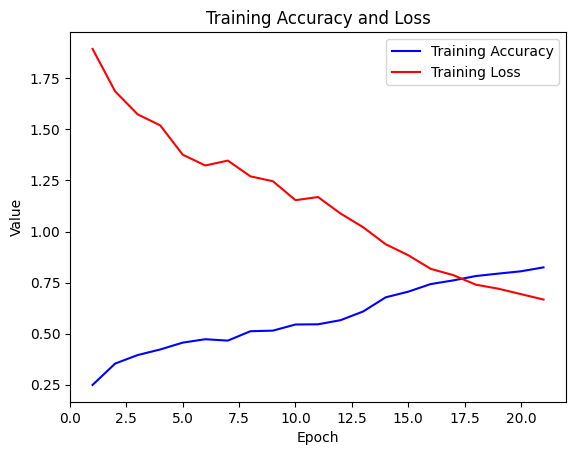

In [34]:
import matplotlib.pyplot as plt

# Define the epoch numbers, accuracy, and loss values
epochs = range(1, 22)  # Assuming 25 epochs
accuracy = [0.2482, 0.3527, 0.3946, 0.4219, 0.4555, 0.4721, 0.4653, 0.5113, 0.5142, 0.5443, 0.5453, 0.5655, 0.6080, 0.6774, 0.7051, 0.7425, 0.7604, 0.7818, 0.7937, 0.8050, 0.8242]  # Replace with actual accuracy values
loss = [1.8947, 1.6868, 1.5741, 1.5201, 1.3763, 1.3235, 1.3475, 1.2704, 1.2462, 1.1536, 1.1689, 1.0881, 1.0211, 0.9376, 0.8839, 0.8169, 0.7862, 0.7394, 0.7197, 0.6931, 0.6666]  # Replace with actual loss values

# Plot the accuracy graph
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.title('Training Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

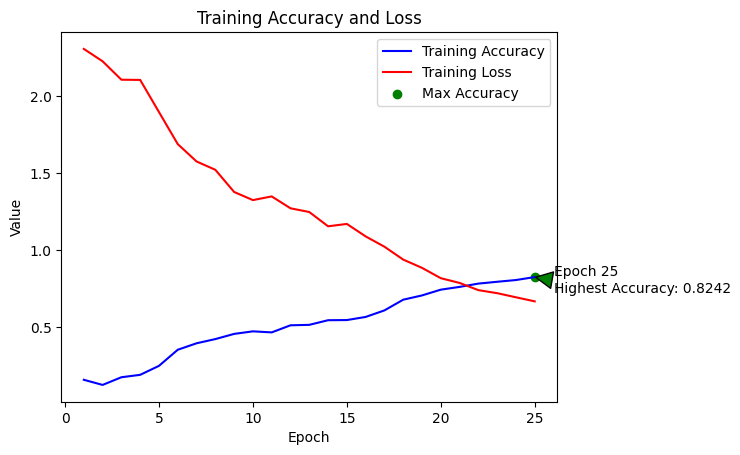

In [41]:
import matplotlib.pyplot as plt

# Define the epoch numbers, accuracy, and loss values
# epochs = range(1, 26)  # Assuming 25 epochs
# accuracy = [0.1578,0.1245 ,0.1743, 0.1900,0.2482, 0.3527, 0.3946, 0.4219, 0.4555, 0.4721, 0.4653, 0.5113, 0.5142, 0.5443, 0.5453, 0.5655, 0.6080, 0.6774, 0.7051, 0.7425, 0.7604, 0.7818, 0.7937, 0.8050, 0.8242]  # Replace with actual accuracy values
# loss = [2.3043,2.2240, 2.1045, 2.1032, 1.8947, 1.6868, 1.5741, 1.5201, 1.3763, 1.3235, 1.3475, 1.2704, 1.2462, 1.1536, 1.1689, 1.0881, 1.0211, 0.9376, 0.8839, 0.8169, 0.7862, 0.7394, 0.7197, 0.6931, 0.6666]  # Replace with actual loss values

# Find the epoch with the highest accuracy
max_accuracy_epoch = epochs[accuracy.index(max(accuracy))]
max_accuracy = max(accuracy)

# Plot the accuracy graph
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.scatter(max_accuracy_epoch, max_accuracy, color='green', label='Max Accuracy')
plt.annotate(f'Epoch {max_accuracy_epoch}\nHighest Accuracy: {max_accuracy:.4f}', xy=(max_accuracy_epoch, max_accuracy), xytext=(max_accuracy_epoch + 1, max_accuracy - 0.1),
             arrowprops=dict(facecolor='green', shrink=0.05))
plt.title('Training Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()


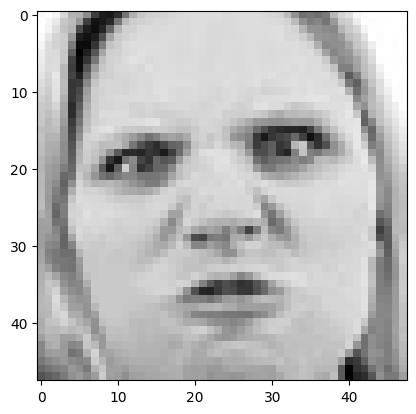

In [12]:
# Read downloaded test image in Opencv
test_img = cv2.imread('/home/deltan/Documents/Emoflix-beta/train/angry/Training_99966135.jpg')
# Take a backup of input image before face detection
img_bcp = test_img.copy()
 
# Show image in OpenCV
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

No faces detected.


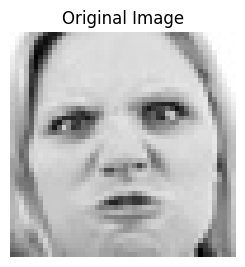

In [24]:
# Convert image to gray scale
gray_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

# Detect faces using the Haar cascade classifier
faces_coordinates = face_classifier.detectMultiScale(gray_img)

# Initialize a list to store cropped faces
cropped_faces = []

# Draw a rectangle around the faces and crop them
for (x, y, w, h) in faces_coordinates:
    # Draw rectangle around face
    cv2.rectangle(test_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Crop face from image
    cropped_face = test_img[y:y+h, x:x+w]
    
    # Append cropped face to the list
    cropped_faces.append(cropped_face)

# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Plot cropped image after performing face detection (if any faces were detected)
if cropped_faces:
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(cropped_faces[-1], cv2.COLOR_BGR2RGB))  # Plot the last cropped face
    plt.title('Cropped Face')
    plt.axis('off')
else:
    print("No faces detected.")

# Show the images
plt.show()

In [25]:
class_dictionary = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
 
final_image = cv2.resize(cropped_face, (224,224))
final_image = np.expand_dims(final_image, axis=0) ## Need 4th dimension
final_image = final_image/255.0 ## Normalizing
 
# Load model
new_model = tf.keras.models.load_model('facial_expression_model.h5')
prediction = new_model.predict(final_image)
class_dictionary[np.argmax(prediction)]

NameError: name 'cropped_face' is not defined

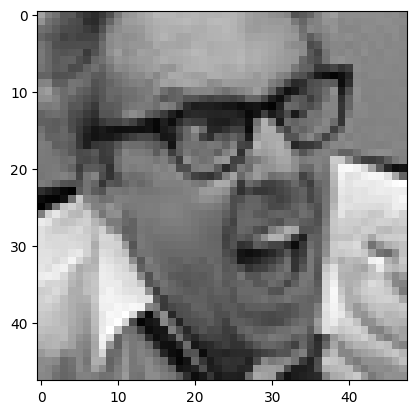

In [49]:
img_3d = np.squeeze(img_bcp)
 
# Define opencv font style
font = cv2.FONT_HERSHEY_PLAIN
 
# Draw a rectangle around the faces
for (x, y, w, h) in faces_coordinates:
    # Draw rectangle around face
    cv2.rectangle(img_3d, (x, y), (x + w, y + h), (0, 255, 0), 2)
 
# Write face emotion class text on image
cv2.putText(img_3d, class_dictionary[np.argmax(prediction)], (250,75),font, 3, (0,0,255), 2, cv2.LINE_4)
 
# Show output image
plt.imshow(cv2.cvtColor(img_3d, cv2.COLOR_BGR2RGB))

In [51]:
import tensorflow as tf
import cv2
 
import os
import matplotlib.pyplot as plt
import numpy as np
 
from keras.preprocessing.image import load_img, img_to_array
 
# Load trained model
new_model = tf.keras.models.load_model('facial_expression_model.h5')
 
# Play video in python
import cv2
 
font_scale = 1.5
font = cv2.FONT_HERSHEY_PLAIN
 
#  Creating class dictionary
class_dictionary = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
 
# Below function will read video imgs
cap = cv2.VideoCapture(
    'Free people expression footage  mad shocked surprised wow amazed face   _ NO COPYRIGHT VIDEOS.mp4')
 
while True:
    read_ok, img = cap.read()
    if not read_ok:
        # If reading the frame fails, break out of the loop
        break
    img_bcp = img.copy()
    cv2.imshow("Play video in python", img)
 
    # Define haar cascade classifier for face detection
    face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
 
    # Convert image to gray scale OpenCV
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
 
    # Detect face using haar cascade classifier
    faces_coordinates = face_classifier.detectMultiScale(gray_img)
 
    # Draw a rectangle around the faces
    for (x, y, w, h) in faces_coordinates:
        # Draw rectangle around face
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
 
        # Crop face from image
        cropped_face = img_bcp[y:y + h, x:x + w]
 
    final_image = cv2.resize(cropped_face, (224, 224))
    final_image = np.expand_dims(final_image, axis=0)
    final_image = final_image / 255.0
 
    predictions = new_model.predict(final_image)
 
    cv2.putText(img, class_dictionary[np.argmax(predictions)], (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)
 
    cv2.imshow('Face Emotion Recognition', img)
 
    # Close video window by pressing 'x'
    if cv2.waitKey(1) & 0xFF == ord('x'):
        break